# a) Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HancModel import HANCModelClass

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w_low,w_high,phi_low,phi_high]
 inputs_hh_z: []
 outputs_hh: [a,c,l_low,l_high]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma,phi_low,phi_high]
 unknowns: [K,L_low,L_high]
 targets: [clearing_A,clearing_L_low,clearing_L_high]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,phi_low,phi_high,L_low,L_high] -> [rK,w_low,w_high,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh,L_LOW_hh,L_HIGH_hh]
 market_clearing: [A,A_hh,L_low,L_high,L_HIGH_hh,L_LOW_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


production_firm: [Gamma,K,phi_low,phi_high,L_low,L_high] -> [rK,w_low,w_high,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh,L_LOW_hh,L_HIGH_hh]
market_clearing: [A,A_hh,L_low,L_high,L_HIGH_hh,L_LOW_hh,Y,C_hh,K] -> [I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


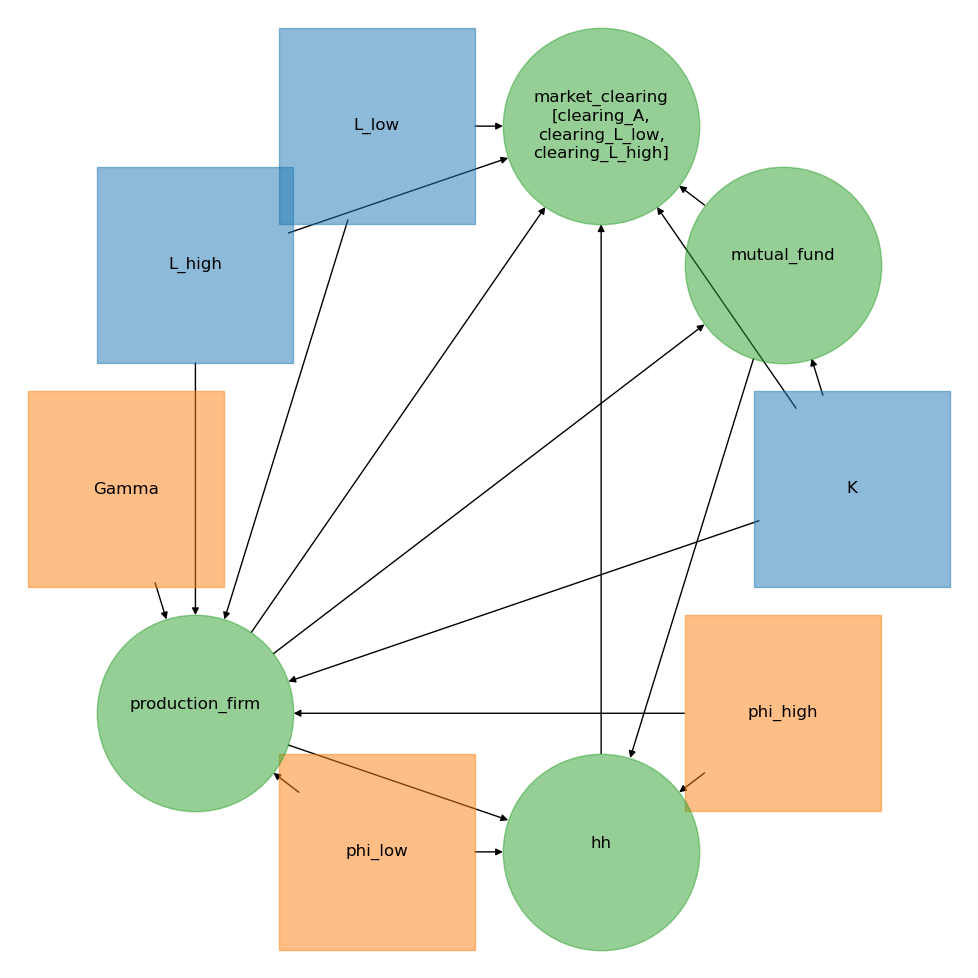

In [4]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

# b) Solve for stationary equilibrium

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [6]:
# Calibration parameters
ss.phi_high = 2.0
ss.phi_low = 1.0
# Some guesses for the steady state for households
ss.rK = 0.05
ss.r = 0.05
ss.w_high = 1.5
ss.w_low = 1.0

In [7]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 8.2 secs [853 iterations]
household problem in ss simulated in 6.0 secs [1172 iterations]


In [8]:
model.find_ss(do_print=True)

### step 1: broad search ###

guess ss.K = 0.1000
implied ss.r = 1.1123
implied ss.w_low = 0.1616
implied ss.w_high = 0.1616
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 0.6211
implied ss.r = 0.2767
implied ss.w_low = 0.3119
implied ss.w_high = 0.3119
household problem in ss solved in 59.5 secs [43978 iterations]
household problem in ss simulated in 0.0 secs [72 iterations]
implied ss.A_hh = 558.0193
clearing_A = -557.39825328

guess ss.K = 1.1421
implied ss.r = 0.1551
implied ss.w_low = 0.3884
implied ss.w_high = 0.3884
household problem in ss solved in 0.5 secs [386 iterations]
household problem in ss simulated in 0.0 secs [129 iterations]
implied ss.A_hh = 530.8128
clearing_A = -529.67070325

guess ss.K = 1.6632
implied ss.r = 0.1005
implied ss.w_low = 0.4447
implied ss.w_high = 0.4447
household problem in ss solved in 0.6 secs [517 iterations]
household problem in ss simulated in 0.1 secs [231 iterations]
implied ss.A_hh = 518.1426
clearing_A = -516.47

In [9]:
# look at the steady state.
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Gamma          : 1.0000
K              : 4.1098
rK             : 0.1124
w_low          : 0.6159
w_high         : 0.6159
Y              : 1.2831
phi_low        : 1.0000
phi_high       : 2.0000
L_low          : 0.6667
L_high         : 0.6667
A              : 4.1098
r              : 0.0124
A_hh           : 4.1098
C_hh           : 0.8722
L_LOW_hh       : 0.6667
L_HIGH_hh      : 0.6667
I              : 0.4110
clearing_A     : 0.0000
clearing_L_low : 0.0000
clearing_L_high: 0.0000
clearing_Y     : 0.0000


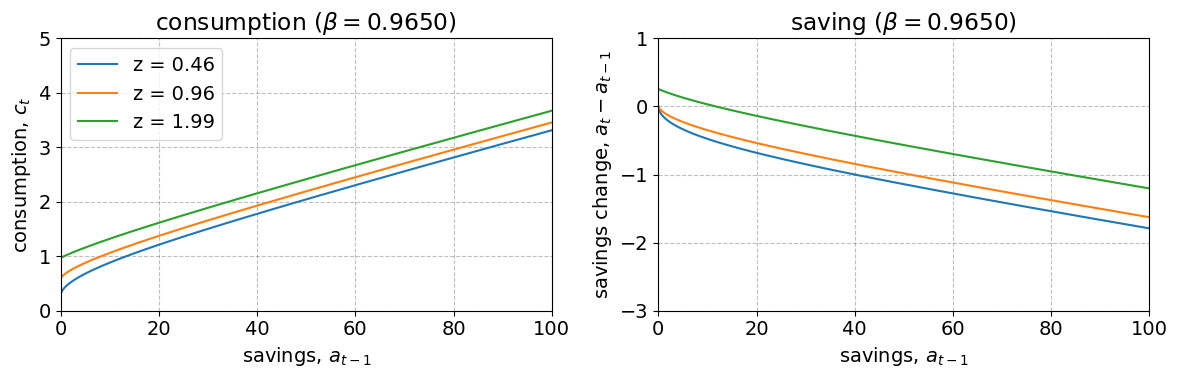

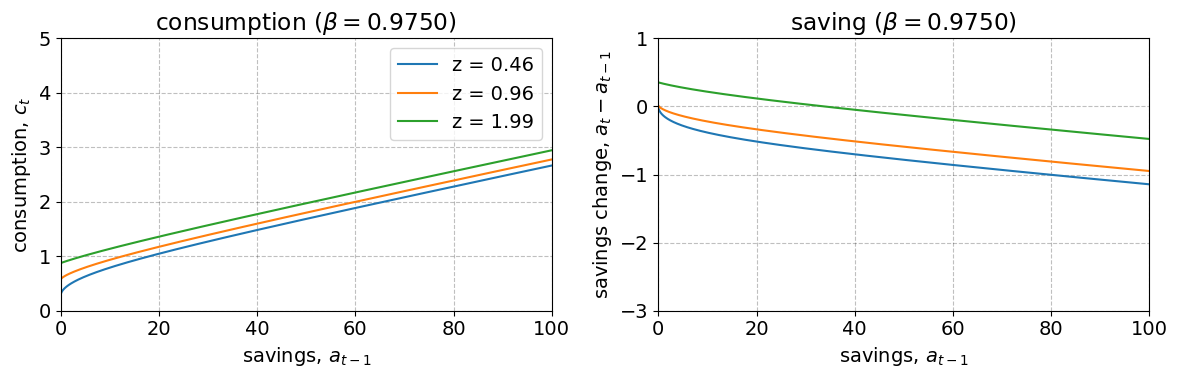

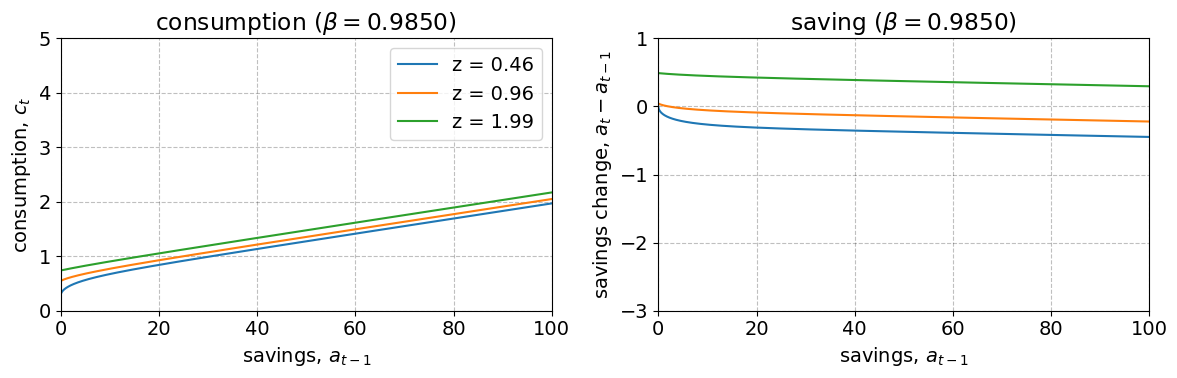

In [10]:
# policy functions
for i_beta,beta in enumerate(par.beta_grid[:3]):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,5)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()

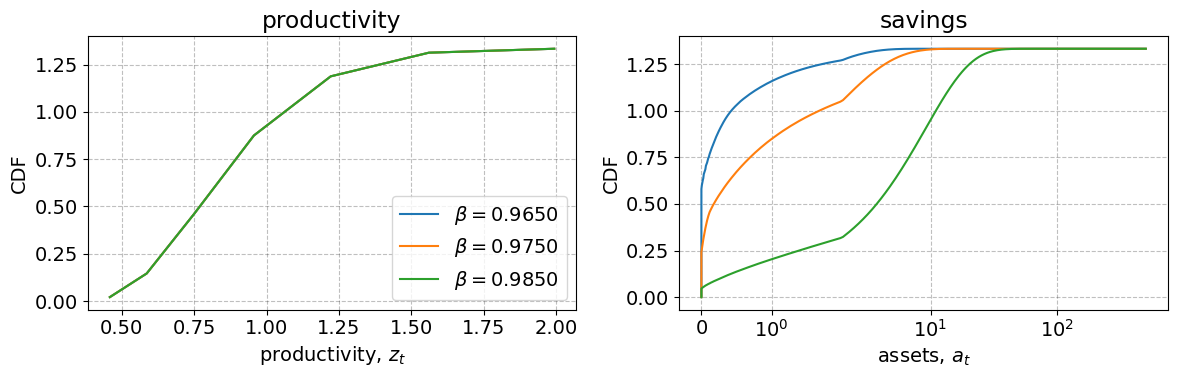

In [11]:
# looking at the distribution
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_beta,beta in enumerate(par.beta_grid[:3]):
    ax.plot(par.z_grid,np.cumsum(np.sum(ss.D[i_beta],axis=1))*par.Nfix,label=f'$\\beta = {beta:.4f}$')

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend()

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(3):
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D[i_beta],axis=0)),0,0.0)*par.Nfix,label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

fig.tight_layout()

# c) Compute and inspect Jacobians of the household wrt. $\phi_1$

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.3 secs
household problem simulated along transition in 1.7 secs



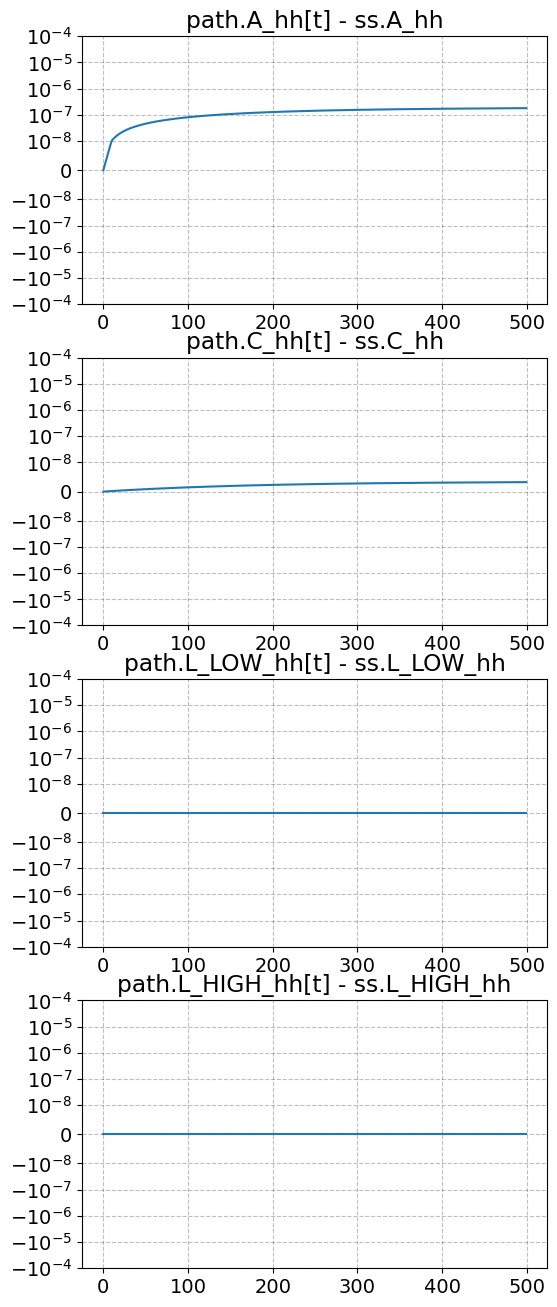

In [12]:
# look if behavior is as expected
model.test_hh_path()

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 2.5 secs]
finding Jacobian wrt. phi_high       : 0 125 250 375 [computed in 2.5 secs]
finding Jacobian wrt. phi_low        : 0 125 250 375 [computed in 2.4 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 2.4 secs]
finding Jacobian wrt. w_high         : 0 125 250 375 [computed in 2.3 secs]
finding Jacobian wrt. w_low          : 0 125 250 375 [computed in 2.2 secs]
household Jacobian computed in 14.7 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 0.9 secs
curly_Y and curly_D calculated for phi_low         in 1.0 secs
curly_Y and curly_D calculated for r               in 0.9 secs
curly_Y and curly_D calculated for w_high          in 0.9 secs
curly_Y and curly_D calculated for w_low           in 1.0 secs
curly_E calculated in 3.0 secs
buili

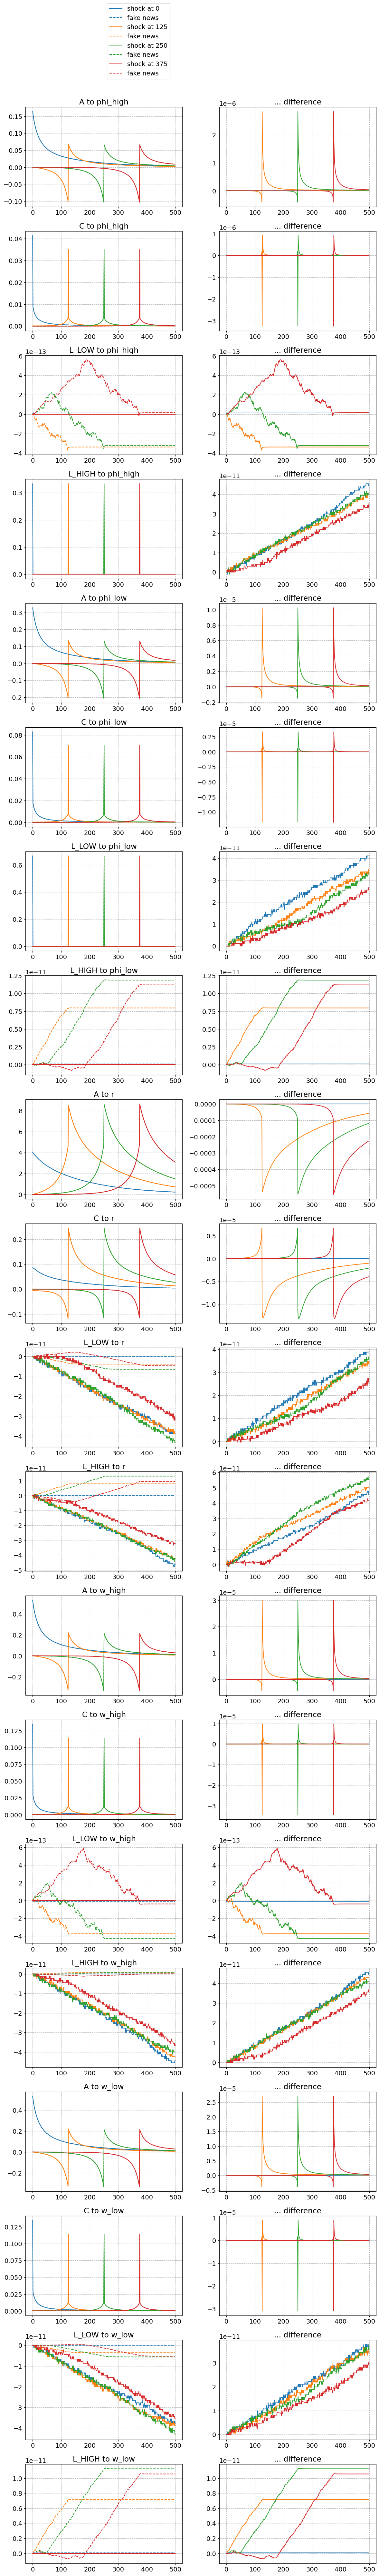

In [13]:
model.test_jacs()

In [14]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 1.0 secs
curly_Y and curly_D calculated for phi_low         in 1.1 secs
curly_Y and curly_D calculated for r               in 1.1 secs
curly_Y and curly_D calculated for w_high          in 1.1 secs
curly_Y and curly_D calculated for w_low           in 1.1 secs
curly_E calculated in 0.9 secs
builiding blocks combined in 1.2 secs
household Jacobian computed in 7.7 secs

full Jacobians:
full Jacobian to unknowns computed in 1.4 secs [in evaluate_blocks(): 0.7 secs]
full Jacobian to shocks computed in 1.4 secs [in evaluate_blocks(): 0.7 secs]


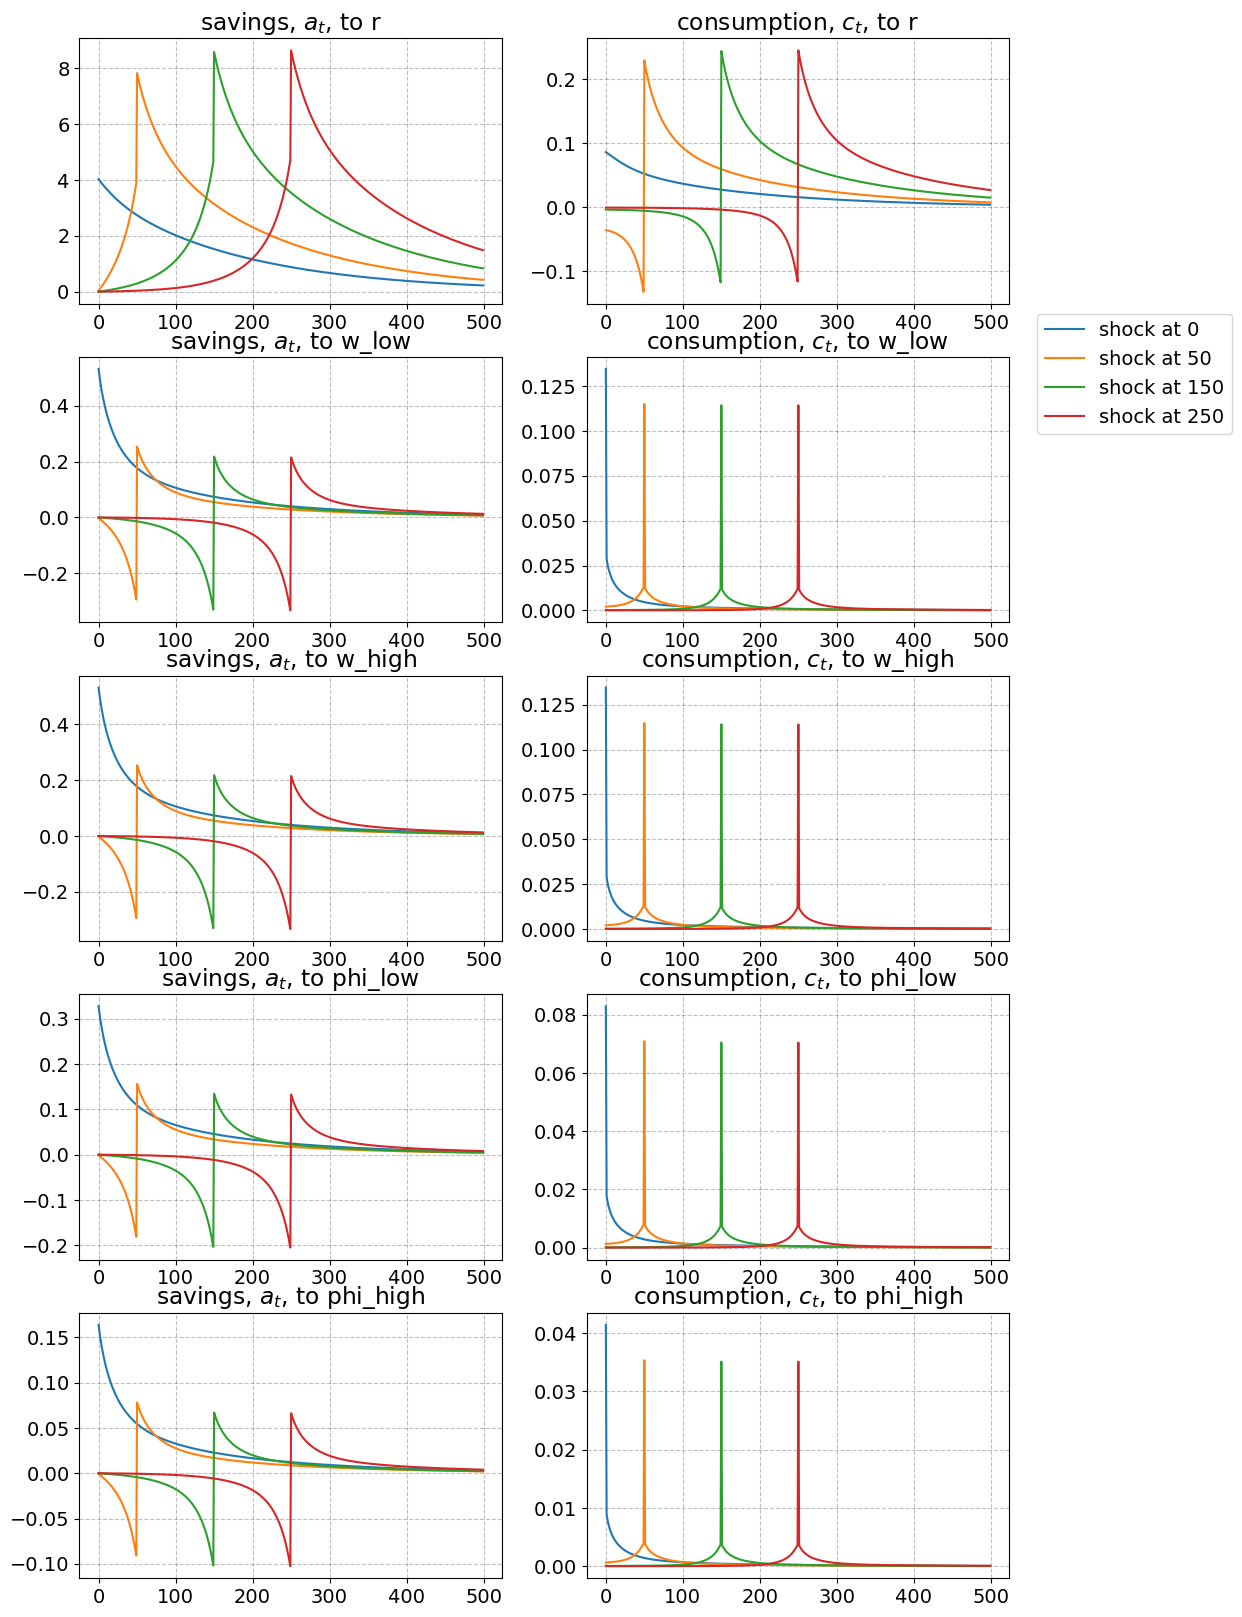

In [15]:
# plot the jacobians
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

# d) Solve for the transition path when $\phi_{1t}$ is 10 percent higher for 10 periods

In [19]:
model.test_path()

shocks: Gamma phi_low phi_high 
unknowns: K L_low L_high 

blocks.production_firm
 rK               0.0e+00
 w_low            0.0e+00
 w_high           0.0e+00
 Y                0.0e+00
blocks.mutual_fund
 A                0.0e+00
 r                0.0e+00
hh
 A_hh             1.8e-07
 C_hh             3.2e-09
 L_LOW_hh         2.0e-15
 L_HIGH_hh        2.0e-15
blocks.market_clearing
 I                    nan
 clearing_A       1.8e-07 [target]
 clearing_L_low   2.1e-14 [target]
 clearing_L_high  2.0e-14 [target]
 clearing_Y       3.2e-09


In [20]:
# a. define shock
dphi_high = np.zeros(par.T)
dphi_high[10:21] = 0.1*ss.phi_high
shocks = {'dphi_high':dphi_high} # note the 'd' for difference (in absolute terms)

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 3.61e-01
   3.61e-01 in clearing_A
   2.45e-14 in clearing_L_low
   6.67e-02 in clearing_L_high
 it =   1 -> max. abs. error = 6.97e-03
   6.97e-03 in clearing_A
   6.66e-16 in clearing_L_low
   7.44e-15 in clearing_L_high
 it =   2 -> max. abs. error = 2.34e-04
   2.34e-04 in clearing_A
   4.44e-16 in clearing_L_low
   4.66e-15 in clearing_L_high
 it =   3 -> max. abs. error = 2.06e-06
   2.06e-06 in clearing_A
   4.44e-16 in clearing_L_low
   3.33e-16 in clearing_L_high
 it =   4 -> max. abs. error = 1.13e-08
   1.13e-08 in clearing_A
   5.55e-16 in clearing_L_low
   2.22e-16 in clearing_L_high
 it =   5 -> max. abs. error = 3.22e-11
   3.22e-11 in clearing_A
   4.44e-16 in clearing_L_low
   4.44e-16 in clearing_L_high
I: terminal value is   0.00000000, but ss value is   0.41098044

transition path found in 9.5 secs


### shocks ###


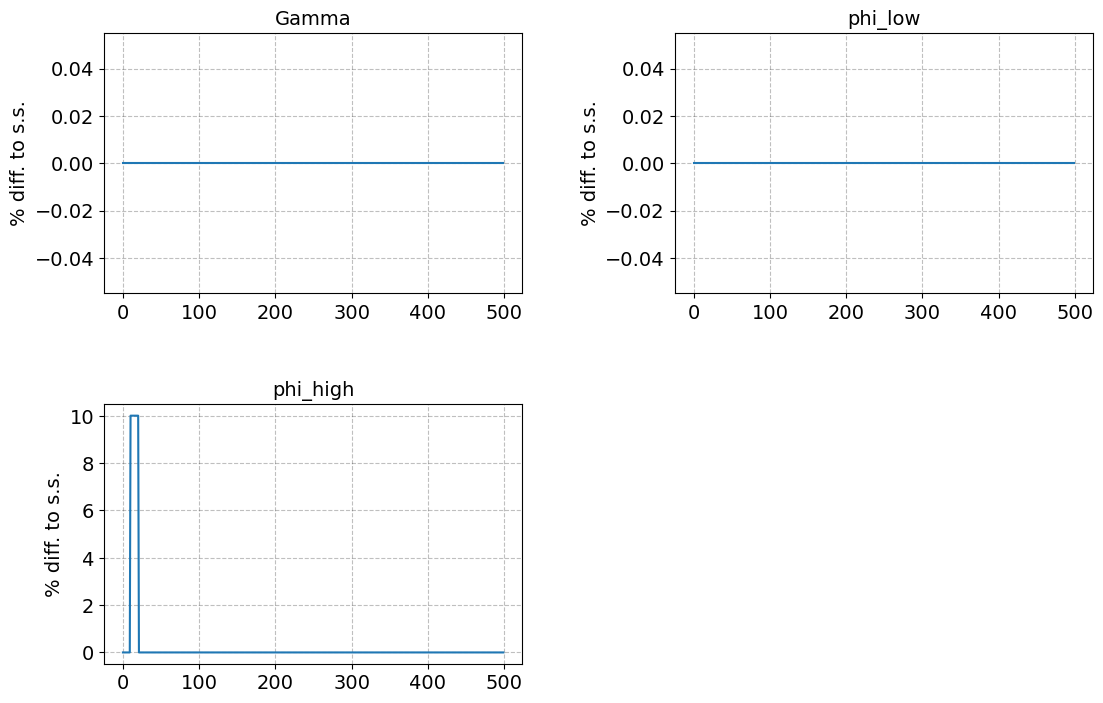


### varnames ###


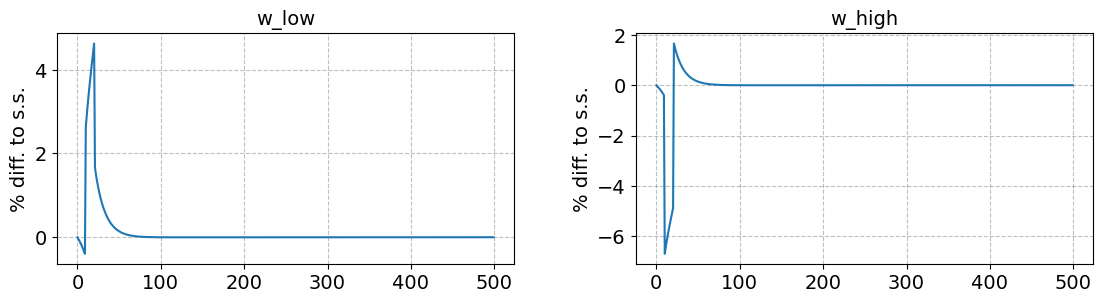


### tagets ###


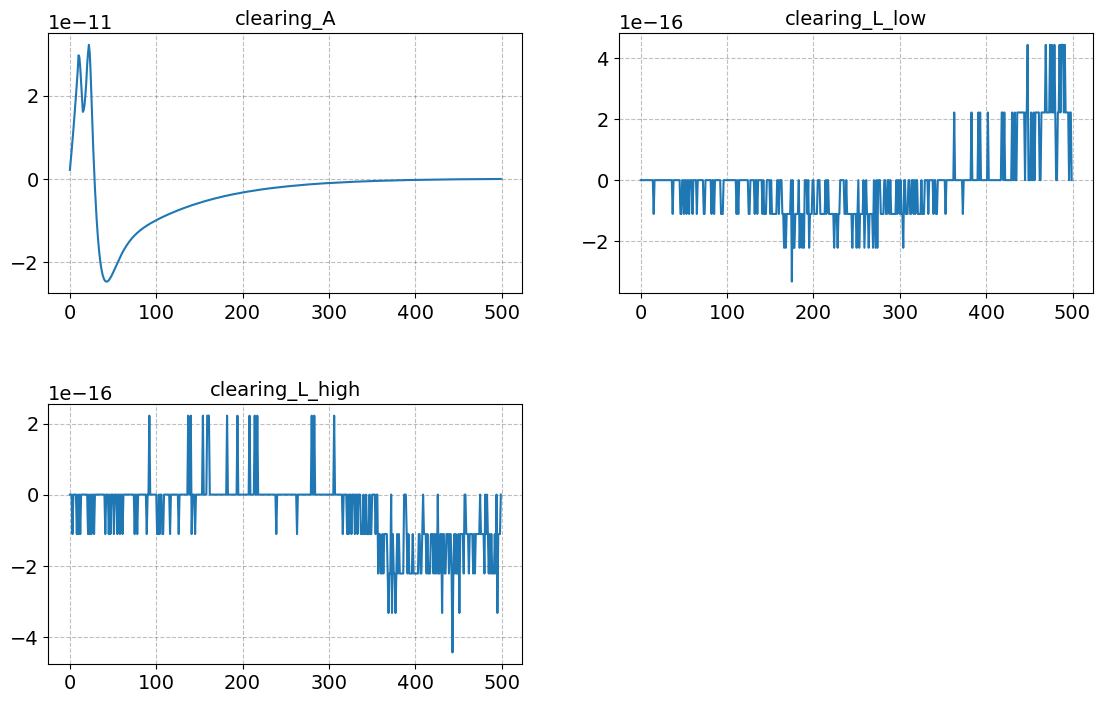

In [21]:
model.show_IRFs(varnames=['w_low','w_high'],ncols=2)

# e) Solve for the transition path when $\phi_{1t}$ is permanently 10 percent higher